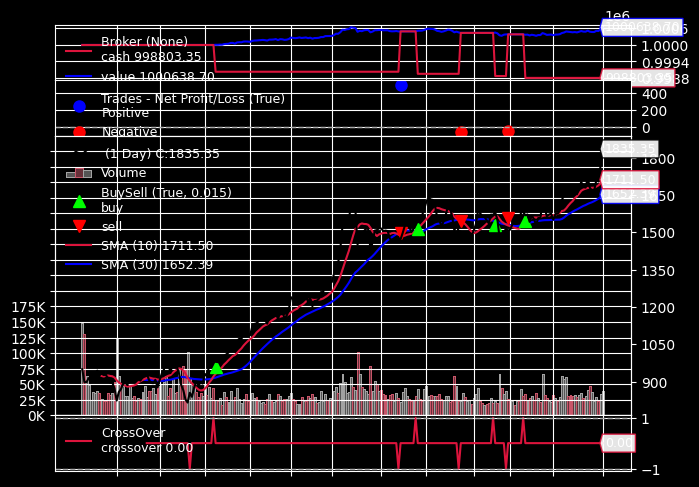

998803.3464449999


In [ ]:
from datetime import datetime
import backtrader as bt
import pandas as pd
import efinance


def get_k_data(stock_code, begin: datetime, end: datetime) -> pd.DataFrame:
    """根据efinance工具包获取股票数据
    :param stock_code:股票代码
    :param begin: 开始日期
    :param end: 结束日期
    """
    # stock_code = '600519'  # 股票代码，茅台
    k_dataframe: pd.DataFrame = efinance.stock.get_quote_history(
        stock_code, beg=begin.strftime("%Y%m%d"), end=end.strftime("%Y%m%d"))
    k_dataframe = k_dataframe.iloc[:, :9]
    k_dataframe.columns = ['name', 'code', 'date', 'open', 'close', 'high', 'low', 'volume', 'turnover']
    k_dataframe.index = pd.to_datetime(k_dataframe.date)
    k_dataframe.drop(['name', 'code', "date"], axis=1, inplace=True)
    return k_dataframe


class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)


if __name__ == '__main__':
    # 获取数据
    start_time = datetime(2020, 1, 1)
    end_time = datetime(2021, 1, 1)
    dataframe = get_k_data('600519', begin=start_time, end=end_time)
    # =============== 为系统注入数据 =================
    # 加载数据
    data = bt.feeds.PandasData(dataname=dataframe, fromdate=start_time, todate=end_time)
    # 初始化cerebro回测系统
    cerebro = bt.Cerebro()  # Cerebro引擎在后台创建了broker(经纪人)实例，系统默认每个broker的初始资金量为10000
    # 将数据传入回测系统
    cerebro.adddata(data)  # 导入数据，在策略中使用 self.datas 来获取数据源
    # 将交易策略加载到回测系统中
    cerebro.addstrategy(SmaCross)
    # =============== 系统设置 ==================
    # 设置启动资金为 100000
    start_cash = 1000000
    cerebro.broker.setcash(start_cash)
    # 设置手续费 万2.5
    cerebro.broker.setcommission(commission=0.00025)
    # 运行回测系统
    cerebro.run()
    cerebro.plot(iplot=False)

    print(cerebro.broker.get_cash())

In [ ]:
from datetime import datetime
import backtrader as bt
import pandas as pd
import efinance
import argparse

def get_k_data(stock_code, begin: datetime, end: datetime) -> pd.DataFrame:
    """根据efinance工具包获取股票数据
    :param stock_code:股票代码
    :param begin: 开始日期
    :param end: 结束日期
    """
    # stock_code = '600519'  # 股票代码，茅台
    k_dataframe: pd.DataFrame = efinance.stock.get_quote_history(
        stock_code, beg=begin.strftime("%Y%m%d"), end=end.strftime("%Y%m%d"))
    k_dataframe = k_dataframe.iloc[:, :9]
    k_dataframe.columns = ['name', 'code', 'date', 'open', 'close', 'high', 'low', 'volume', 'turnover']
    k_dataframe.index = pd.to_datetime(k_dataframe.date)
    k_dataframe.drop(['name', 'code', "date"], axis=1, inplace=True)
    return k_dataframe


class SmaCross(bt.SignalStrategy):
    params = (('period1', 10),
              ('period2', 30),
              )

    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=self.p.period1), bt.ind.SMA(period=self.p.period2)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)


start_time = datetime(2020, 1, 1)
end_time = datetime(2021, 1, 1)
dataframe = get_k_data('600519', begin=start_time, end=end_time)
# =============== 为系统注入数据 =================
# 加载数据
data = bt.feeds.PandasData(dataname=dataframe, fromdate=start_time, todate=end_time)


def backtest(p) -> float:
    p1, p2 = p
    strategy = SmaCross
    # 初始化cerebro回测系统
    cerebro = bt.Cerebro()  # Cerebro引擎在后台创建了broker(经纪人)实例，系统默认每个broker的初始资金量为10000
    # 将数据传入回测系统
    cerebro.adddata(data)  # 导入数据，在策略中使用 self.datas 来获取数据源
    # 将交易策略加载到回测系统中
    cerebro.addstrategy(strategy, period1=int(p1), period2=int(p2))
    # =============== 系统设置 ==================
    # 设置启动资金为 100000
    start_cash = 1000000
    cerebro.broker.setcash(start_cash)
    # 设置手续费 万2.5
    cerebro.broker.setcommission(commission=0.00025)
    # 运行回测系统
    cerebro.run()
    print(-(start_cash - cerebro.broker.get_cash()))
    return -(start_cash - cerebro.broker.get_cash())

from sko.GA import GA
ga = GA(func=backtest, n_dim=2, size_pop=10, max_iter=100, prob_mut=0.001, lb=[1, 1], ub=[50, 50], precision=1e-7)
best_x, best_y = ga.run()
print('best_x:', best_x, '\n', 'best_y:', best_y)

# from sko.DE import DE
# de = DE(func=backtest, n_dim=2, size_pop=10, max_iter=100, lb=[1, 1], ub=[50, 50])
# best_x, best_y = de.run()
# print('best_x:', best_x, '\n', 'best_y:', best_y)

# from sko.PSO import PSO
# pso = PSO(func=backtest, n_dim=2, pop=10, max_iter=100, lb=[1, 1], ub=[50, 50], w=0.8, c1=0.5, c2=0.5)
# pso.run()
# print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

85.70115249999799
-24.87622500024736
117.27054000005592
-1310.331445000018
-19.778924999991432
-1220.7648300001165
-1211.022467500181
160.18601999990642
-1552.7380874999799
-1042.1920674998546
-1120.7757125000935
-1149.6308150000405
301.2451999998884
-1179.9997925000498
-1165.2692124999594
-1315.4246700002113
354.04548749991227
-0.0
203.34605750022456
-1463.3877350005787
-1170.1321750000352
-1179.9997925000498
346.1161874998361
-1179.9997925000498
-1179.9997925000498
226.49335250002332
234.7345375000732
-0.0
548.7333125004079
-0.0
-1274.8818050000118
-1207.4099700001534
447.0407975000562
-1207.4099700001534
-1179.9997925000498
325.00576000020374
335.4963399999542
-0.0
-0.0
-0.0
-1371.1938724997453
-1259.1423699998995
-0.0
-1297.914790000068
-1179.9997925000498
408.0952474998776
361.3515924998792
96.21625249984208
-0.0
-0.0
-0.0
-1539.3874574996298
-0.0
-1463.3877350005787
-1218.1145300000207
-1440.1650449997978
345.0626600001706
139.05845749995206
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-1364.14

In [1]:
import backtrader
from loguru import logger
import pandas as pd
import efinance
from datetime import datetime, timedelta


def get_k_data(stock_code, begin: datetime, end: datetime) -> pd.DataFrame:
    """
    根据efinance工具包获取股票数据
    :param stock_code:股票代码
    :param begin: 开始日期
    :param end: 结束日期
    :return:
    """
    # stock_code = '600519'  # 股票代码，茅台
    k_dataframe: pd.DataFrame = efinance.stock.get_quote_history(
        stock_code, beg=begin.strftime("%Y%m%d"), end=end.strftime("%Y%m%d"))
    k_dataframe = k_dataframe.iloc[:, :9]
    k_dataframe.columns = ['name', 'code', 'date', 'open', 'close', 'high', 'low', 'volume', 'turnover']
    k_dataframe.index = pd.to_datetime(k_dataframe.date)
    k_dataframe.drop(['name', 'code', 'date'], axis=1, inplace=True)
    return k_dataframe


class MyStrategy1(backtrader.Strategy):  # 策略
    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.close_price = self.datas[0].close  # 这里加一个数据引用，方便后续操作
        self.sma = backtrader.indicators.SimpleMovingAverage(self.datas[0], period=5)  # 借用这个策略，计算5日的均线
        self.order_list = []

    def notify_order(self, order):  # 固定写法，查看订单情况
        # 查看订单情况
        if order.status in [order.Submitted, order.Accepted]:  # 接受订单交易，正常情况
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                logger.debug('{} 已买入, 购入金额 {} 手续费 {}', order.ref, order.executed.value, order.executed.comm)
            elif order.issell():
                logger.debug('{} 已卖出, 卖出金额 {} 手续费 {}', order.ref, order.executed.value, order.executed.comm)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            logger.debug('{} 订单取消、保证金不足、金额不足拒绝交易', order.ref)
        elif order.status in [order.Expired]:
            logger.debug("订单 {} 超过时效，已取消", order.ref)

    def next(self):  # 固定的函数，框架执行过程中会不断循环next()，过一个K线，执行一次next()
        if self.close_price[0] > self.sma[0]:
            # 执行买入
            # 获得默认的保证金：self.broker.comminfo[None].p.commission
            order = self.buy(size=500, price=self.data.close[0],
                             exectype=backtrader.Order.Limit, valid=timedelta(days=1))
            logger.debug('订单：买 {} ', order.ref)
            self.order_list.append(order)
        # 执行卖出条件已有持仓，且收盘价格跌破5日均线
        if self.position:
            if self.close_price[0] < self.sma[0]:
                # 执行卖出
                order = self.sell(size=500, price=self.data.close[0], exectype=backtrader.Order.Limit,
                                  valid=timedelta(days=1))
                logger.debug('订单：卖 {} ', order.ref)
                self.order_list.append(order)


if __name__ == '__main__':
    # 获取数据
    start_time = datetime(2020, 1, 1)
    end_time = datetime(2021, 1, 1)
    dataframe = get_k_data('600519', begin=start_time, end=end_time)
    # =============== 为系统注入数据 =================
    # 加载数据
    data = backtrader.feeds.PandasData(dataname=dataframe, fromdate=start_time, todate=end_time)
    # 初始化cerebro回测系统
    cerebral_system = backtrader.Cerebro()  # Cerebro引擎在后台创建了broker(经纪人)实例，系统默认每个broker的初始资金量为10000
    # 将数据传入回测系统
    cerebral_system.adddata(data)  # 导入数据，在策略中使用 self.datas 来获取数据源
    # 将交易策略加载到回测系统中
    cerebral_system.addstrategy(MyStrategy1)
    # =============== 系统设置 ==================
    # 设置启动资金为 100000
    start_cash = 1000000
    cerebral_system.broker.setcash(start_cash)
    # 设置手续费 万2.5
    cerebral_system.broker.setcommission(commission=0.00025)
    logger.debug('初始资金: {} 回测期间：from {} to {}'.format(start_cash, start_time, end_time))
    # 运行回测系统
    cerebral_system.run()
    # 获取回测结束后的总资金
    portvalue = cerebral_system.broker.getvalue()
    pnl = portvalue - start_cash
    # 打印结果
    logger.debug('净收益: {}', pnl)
    logger.debug("总资金: {}", portvalue)


/home/renjunji_2023/miniconda3/envs/backtrader/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-17 14:27:57.132 | DEBUG    | __main__:<module>:85 - 初始资金: 1000000 回测期间：from 2020-01-01 00:00:00 to 2021-01-01 00:00:00
2025-02-17 14:27:57.162 | DEBUG    | __main__:next:53 - 订单：买 1 
2025-02-17 14:27:57.163 | DEBUG    | __main__:notify_order:39 - 1 已买入, 购入金额 461510.0 手续费 115.3775
2025-02-17 14:27:57.164 | DEBUG    | __main__:next:53 - 订单：买 2 
2025-02-17 14:27:57.165 | DEBUG    | __main__:notify_order:45 - 订单 2 超过时效，已取消
2025-02-17 14:27:57.166 | DEBUG    | __main__:next:53 - 订单：买 3 
2025-02-17 14:27:57.167 | DEBUG    | __main__:notify_order:39 - 3 已买入, 购入金额 472260.0 手续费 118.065
2025-02-17 14:27:57.168 | DEBUG    | __main__:next:53 - 订单：买 4 
2025-02-17 14:27:57.169 | DEBUG    | __main__:notify_order:43 - 